In [1]:
using Plots, LaTeXStrings
include("solar_insolation.jl");
using .SolarInsolationModel

# Parameters

In [2]:
# Vehicle Parameters
Base.@kwdef struct ASV_Params
    b_max::Float32 = 6500; # max soc in Wh
    b_min::Float32 = 0; # min soc in Wh
    panel_area::Float32 = 4; # m^2
    panel_efficiency::Float32 = 0.25; # 25% panel efficiency
    v_max::Float32 = 2.315; # max boat speed in m/s 
    v_min::Float32 = 0; # min boat speed in m/s

    k_h::Float32 = 10; # Hotel Load
    k_m::Float32 = 83; # Motor multiplier, need to tune
end

boat = ASV_Params();

# Environment Parameters
# dayOfYear = 180;
dayOfYear = 180;
lat = 35.0; # degrees
Δt = 0.1; # time step in hours
t = 0:Δt:24;
og_time = t;
t = t .+ 12;
t = t .% 24; # time over a day from noon to noon
n = length(t);

# Initial Conditions
b_0 = boat.b_max/2;

# Solar Irradiance

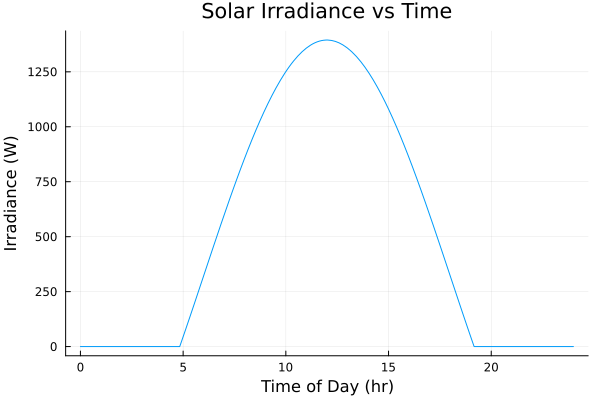

In [3]:
plot(solarTime -> max(0,SolarInsolation(dayOfYear, solarTime, lat))*1000, 0, 24);
xlabel!("Time of Day (hr)");
ylabel!("Irradiance (W)");
title!("Solar Irradiance vs Time");
plot!(legend=false)

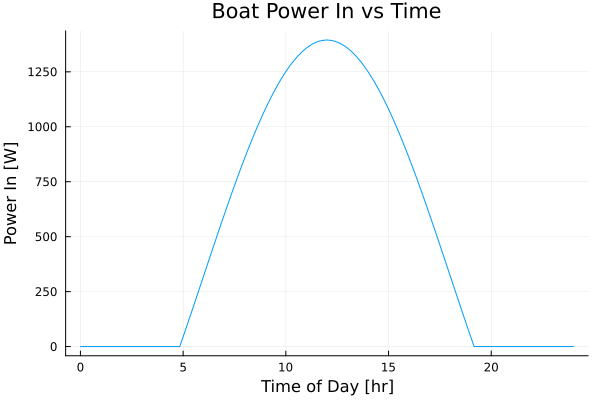

In [4]:
plot(solarTime -> max(0,SolarInsolation(dayOfYear, solarTime, lat))*1000*boat.panel_area*boat.panel_efficiency, 0, 24);
xlabel!("Time of Day [hr]");
ylabel!("Power In [W]");
title!("Boat Power In vs Time");
plot!(legend=false)

# Lower Barrier
We can first compute an "energy deficit curve" across the mission horizon

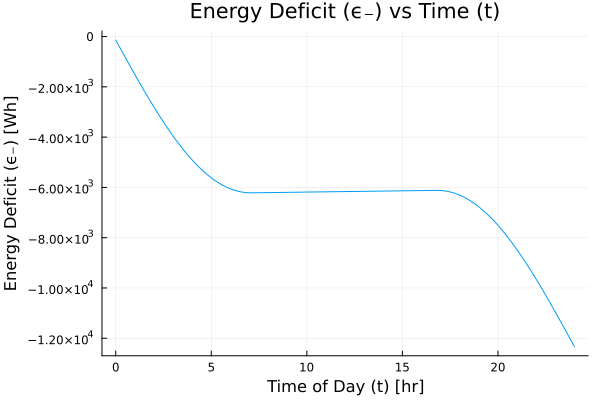

In [5]:
ϵ₋ = zeros(n); # energy deficit
Ps = zeros(n);
for i = 1:n
    Ps[i] = max(0, SolarInsolation(dayOfYear, t[i], lat))*1000* boat.panel_area * boat.panel_efficiency;
    ϵ₋[i] = boat.k_h*(og_time[i] - og_time[1]) - sum(Ps[1:i]*Δt);
end

plot(og_time, ϵ₋);
xlabel!("Time of Day (t) [hr]");
ylabel!("Energy Deficit (ϵ₋) [Wh]");
title!("Energy Deficit (ϵ₋) vs Time (t)");
plot!(legend=false)

At each time $t_1 \in [t_0, t_f]$, we shift the energy deficit curve such that $\epsilon_{-}(t_1) = 0$. We define this as
$$
\epsilon_{-}^{\dagger}(t) = \epsilon_{-}(t) - \epsilon_{-}(t_1) \text{ where } t = [t_0, t_f] \text{ and } \forall t_1 \in [t_0, t_f]
$$
Then, we define the lower barrier function $h_l$:
$$
\begin{align*}
h_{temp} &= \max_{t_2 \in [t_1, t_f]} \epsilon_{-}^{\dagger}(t_2)\\
h_{l}(t_1) &= \begin{cases}
h_{temp} & h_{temp} > 0\\
0 & else
\end{cases}
\end{align*}
$$

┌ Info: Saved animation to /home/kmgovind/Documents/research/cps/characterizing-ive/lower_epsAdjust.gif
└ @ Plots /home/kmgovind/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/home/kmgovind/Documents/research/cps/characterizing-ive/lower_epsAdjust.gif")
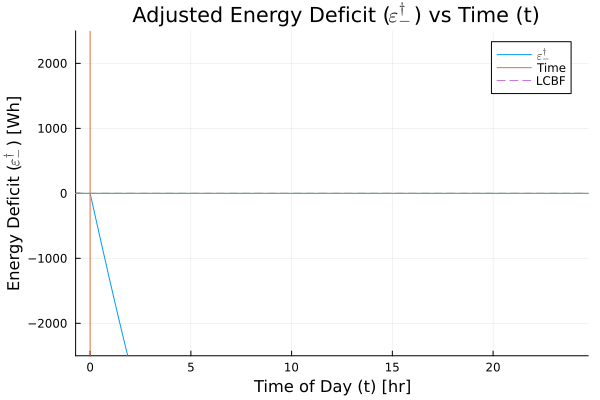

In [6]:
epsAdjust = @animate for i = 1:n
    # Compute Adjusted Energy Deficit curve
    ϵ₋dag = ϵ₋ .- ϵ₋[i];
    lcbf = max(0, maximum(ϵ₋dag[i:end]));

    # Plot
    plot(og_time, ϵ₋dag, label=L"$\epsilon_{-}^{\dagger}$");
    ylims!(-2500, 2500);
    vline!([og_time[i]], label="Time");
    hline!([0], label=false);
    hline!([lcbf], linestyle=:dash, label="LCBF");
    xlabel!("Time of Day (t) [hr]");
    ylabel!(L"Energy Deficit ($\epsilon_{-}^{\dagger}$) [Wh]");
    title!(L" Adjusted Energy Deficit ($\epsilon_{-}^{\dagger}$) vs Time (t)");
    plot!()
end
gif(epsAdjust, "lower_epsAdjust.gif")

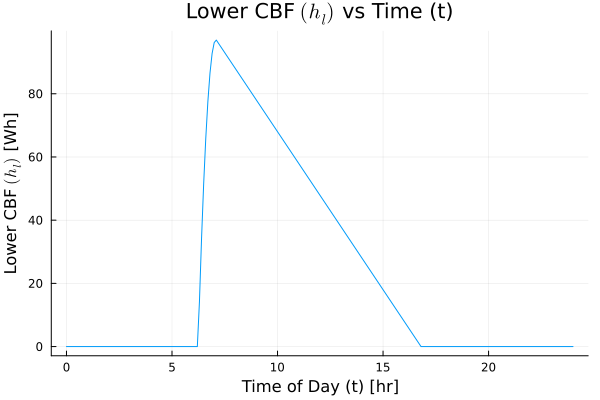

In [7]:
lcbf = zeros(n);

for i = 1:n
    ϵ₋dag = ϵ₋ .- ϵ₋[i];
    lcbf[i] = max(0, maximum(ϵ₋dag[i:end]));
end
plot(og_time, lcbf);
xlabel!("Time of Day (t) [hr]");
ylabel!(L"Lower CBF $(h_l)$ [Wh]");
title!(L"Lower CBF $(h_l)$ vs Time (t)");
plot!(legend=false)

# Upper Barrier
We compute the additional energy by
$$
\epsilon_{+}(t) = P_s(t) - k_h - k_m u^3(t)
$$

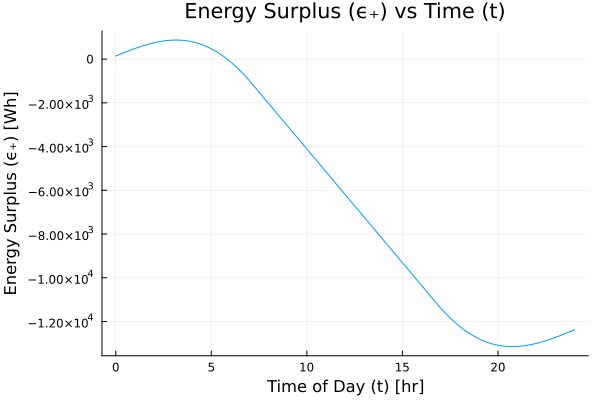

In [8]:
ϵ₊ = zeros(n); # energy surplus
Ps = zeros(n);
for i = 1:n
    Ps[i] = max(0, SolarInsolation(dayOfYear, t[i], lat))*1000* boat.panel_area * boat.panel_efficiency;
    # boat.k_h*(og_time[i] - og_time[1])
    ϵ₊[i] = sum(Ps[1:i]*Δt) - (boat.k_h + boat.k_m*(boat.v_max^3))*(og_time[i] - og_time[1]);
end

plot(og_time, ϵ₊);
xlabel!("Time of Day (t) [hr]");
ylabel!("Energy Surplus (ϵ₊) [Wh]");
title!("Energy Surplus (ϵ₊) vs Time (t)");
plot!(legend=false)

At each time $t_1 \in [t_0, t_f]$, we shift the energy surplus curve such that $\epsilon_{+}(t_1) = 0$. We define this as
$$
\epsilon_{+}^{\dagger}(t) = \epsilon_{+}(t) - \epsilon_{+}(t_1) \text{ where } t = [t_0, t_f] \text{ and } \forall t_1 \in [t_0, t_f]
$$
Then, we define the upper barrier function $h_u$:
$$
\begin{align*}
h_{temp} &= \max_{t_2 \in [t_1, t_f]} \epsilon_{+}^{\dagger}(t_2)\\
h_{u}(t_1) &= \begin{cases}
h_{temp} & h_{temp} > b_{max}\\
b_{max} & else
\end{cases}
\end{align*}
$$

┌ Info: Saved animation to /home/kmgovind/Documents/research/cps/characterizing-ive/upper_epsAdjust.gif
└ @ Plots /home/kmgovind/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/home/kmgovind/Documents/research/cps/characterizing-ive/upper_epsAdjust.gif")
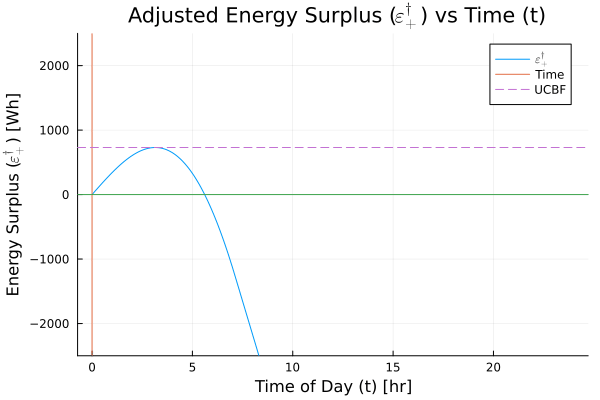

In [9]:
epsAdjust = @animate for i = 1:n
    # Compute Adjusted Energy Deficit curve
    ϵ₊dag = ϵ₊ .- ϵ₊[i];
    ucbf = max(0, maximum(ϵ₊dag[i:end]));

    # Plot
    plot(og_time, ϵ₊dag, label=L"$\epsilon_{+}^{\dagger}$");
    ylims!(-2500, 2500);
    vline!([og_time[i]], label="Time");
    hline!([0], label=false);
    hline!([ucbf], linestyle=:dash, label="UCBF");
    xlabel!("Time of Day (t) [hr]");
    ylabel!(L"Energy Surplus ($\epsilon_{+}^{\dagger}$) [Wh]");
    title!(L" Adjusted Energy Surplus ($\epsilon_{+}^{\dagger}$) vs Time (t)");
    plot!()
end
gif(epsAdjust, "upper_epsAdjust.gif")

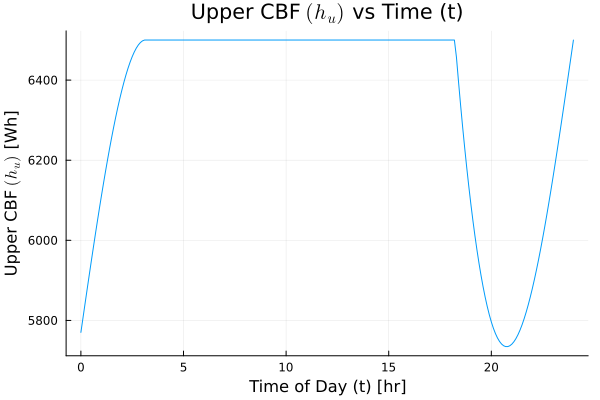

In [10]:
ucbf = zeros(n);

for i = 1:n
    ϵ₊dag = ϵ₊ .- ϵ₊[i];
    ucbf[i] = boat.b_max - max(0, maximum(ϵ₊dag[i:end]));
end
plot(og_time, ucbf);
xlabel!("Time of Day (t) [hr]");
ylabel!(L"Upper CBF $(h_u)$ [Wh]");
title!(L"Upper CBF $(h_u)$ vs Time (t)");
plot!(legend=false)

# Combined Barrier

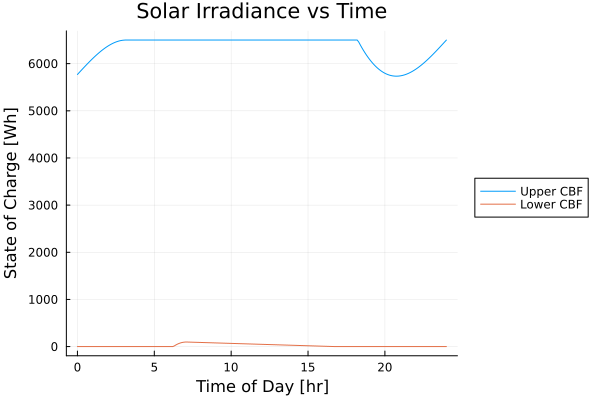

In [11]:
plot(og_time, ucbf, label="Upper CBF");
plot!(og_time, lcbf, label="Lower CBF");
xlabel!("Time of Day [hr]");
ylabel!("State of Charge [Wh]");
title!("Solar Irradiance vs Time");
plot!(legend=:outerright)

# Velocity Trajectory Optimization
## Velocity Costate
$$
u = \sqrt{\frac{-1}{3 p_2 k_m}}
$$
re-arranging for $p_2$:
$$
p_2 = \frac{-1}{3 k_m u^2}
$$

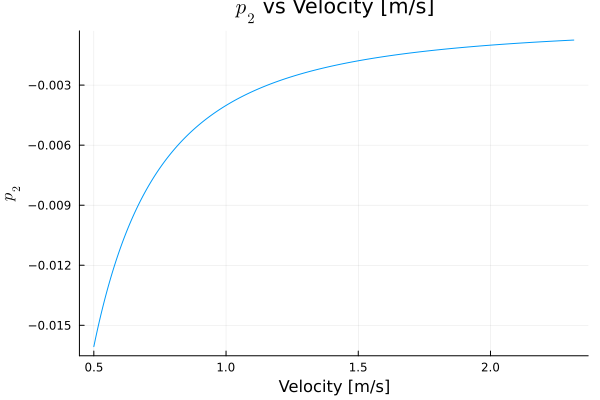

In [12]:
u = 0.5:0.001:boat.v_max;
p2_sample = -1 ./ (3 .* boat.k_m .* u.^2);
plot(u, p2_sample);
xlabel!("Velocity [m/s]");
ylabel!(L"$p_2$");
title!(L"$p_2$ vs Velocity [m/s]");
plot!(legend=false)

As seen above, this is a non-linear relationship. To make it easier to pick $p_2$, let us linearize it.

We can represent the equation for $p_2$ in the general form of the power equation
$$
\begin{align*}
y &= ax^b\\
y &= p_2\\
a &= \frac{-1}{3 k_m}\\
x &= u\\
b &= -2\\
\end{align*}
$$
The linearized form of this equation is given by:
$$
\begin{align*}
\log(y) &= b \log(x) + \log(a)
\end{align*}
$$

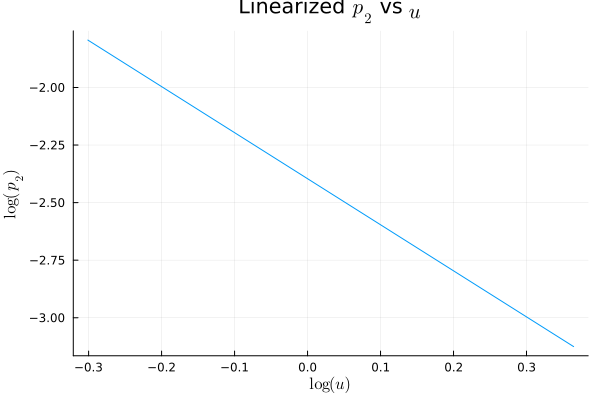

In [13]:
beta = -2;
alpha = 1/(3*boat.k_m);
p2_prime = beta .* log10.(u) .+ log10(alpha);
logp2_max = min(maximum(p2_prime), 10e4);
logp2_min = minimum(p2_prime);
plot(log10.(u), p2_prime);
xlabel!(L"$\log(u)$");
ylabel!(L"$\log(p_2)$");
title!(L"Linearized $p_2$ vs $u$");
plot!(legend=false)

## Naive Strategy - Constant Max Velocity
For this strategy, we pick $p_2$ such that the maximum velocity is selected. When the SOC intersects the CBFs, then we switch accordingly.

p2min: 0.000749374


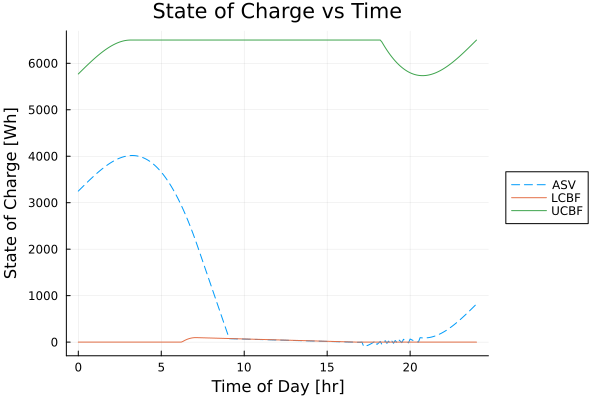

In [14]:
function batterymodel!(boat, dayOfYear, time, lat, vel, soc, dt)
    # Solar Insolation returns in kW
    p_in = max(0,SolarInsolation(dayOfYear, time, lat))* 1000 * boat.panel_area * boat.panel_efficiency;
    p_out = boat.k_h + boat.k_m * (vel^3);
    soc_est = soc + (p_in - p_out)*dt; # power update in Wh
    soc_est = min(soc_est, boat.b_max); # cap charge at soc_max
    return soc_est;
end

function powermodel!(boat, dayOfYear, time, lat, vel, soc, dt)
    # Solar Insolation returns in kW
    p_in = max(0,SolarInsolation(dayOfYear, time, lat))* 1000 * boat.panel_area * boat.panel_efficiency;
    p_out = boat.k_h + boat.k_m * (vel^3);
    out = p_in - p_out;
    return out;
end

function zeropower!(boat, dayOfYear, time, lat, soc, dt)
    p_in = max(0,SolarInsolation(dayOfYear, time, lat))* 1000 * boat.panel_area * boat.panel_efficiency;
    if p_in < boat.k_h
        vel = 0;
    else
        vel = cbrt((p_in - boat.k_h)/boat.k_m);
    end
    return vel;
end

xmax = 0; # best distance travel
pstar = 0;
num_iters = 15;
p_list = zeros(num_iters);
p_list[1] = 0.5; # Initial guess for p2
p2min = 1/(3*boat.k_m*(boat.v_max^2));
println("p2min: ", p2min);

x = zeros(n);
b = ones(n)*b_0;
v = ones(n)*boat.v_max;
p2 = p2min;

for j in 2:n
    i = j-1;
    if i == 1 # initial conditions
        global x[i] = 0;
        global b[i] = b_0;
    end
    # println(p2);
    # Compute unconstrained velocity and SOC
    global v[i] = sqrt(1/(3 * p2 * boat.k_m)); # removed negative sign from numerator to let p be positive
    b_dot = powermodel!(boat, dayOfYear, t[i], lat, v[i], b[i], Δt);

    if b[i] <= lcbf[i]
        global v[i] = 0;
    elseif b[i] >= ucbf[i]
        global v[i] = boat.v_max;
    end

    # Move boat
    global x[j] = x[i] + (v[i] * 60 * 60) * Δt;
    global b[j] = batterymodel!(boat, dayOfYear, t[i], lat, v[i], b[i], Δt);
end

# Plot SOC vs Time
plot(og_time, b, linestyle=:dash, label="ASV");
plot!(og_time, lcbf, label="LCBF");
plot!(og_time, ucbf, label="UCBF");
xlabel!("Time of Day [hr]");
ylabel!("State of Charge [Wh]");
title!("State of Charge vs Time");
plot!(legend=:outerright)
# savefig("soc_v_time.png")


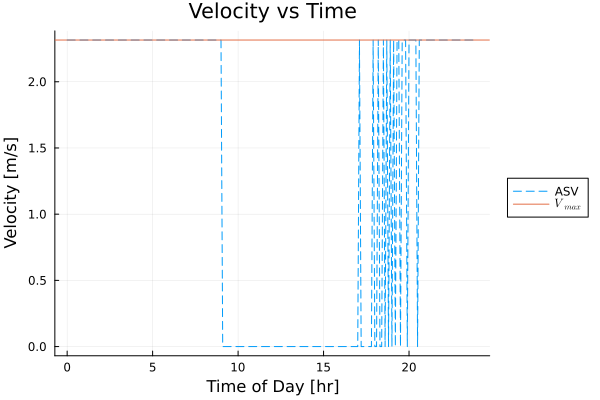

In [15]:
# Plot Velocity vs Time
plot(og_time, v, linestyle=:dash, label="ASV");
hline!([boat.v_max], label=L"$V_{max}$");
xlabel!("Time of Day [hr]");
ylabel!("Velocity [m/s]");
title!("Velocity vs Time");
plot!(legend=:outerright)

## Testing the Normalization Function

In [16]:
b_norm = (boat.b_max - boat.b_min)/(boat.b_max - boat.b_min);
b_norm_des = (boat.b_max/2 - boat.b_min)/(boat.b_max - boat.b_min);
Δb = b_norm_des - b_norm;
println("b_norm: ", b_norm);
println("b_norm_des: ", b_norm_des);
println("Δb: ", Δb);
uprime = b_norm * (boat.v_max - boat.v_min) + boat.v_min;
println("uprime: ", uprime);
logp2 = beta * log10(uprime) + log10(alpha);
println("p2min: ", p2min);
pnew = min(10^logp2, 10e3);
println("pnew: ", pnew);

b_norm: 1.0
b_norm_des: 0.5
Δb: -0.5
uprime: 2.315
p2min: 0.000749374
pnew: 

0.0007493740413337946


## Iterative Co-state Learning

p2min: 0.000749374
0.5


0.46394874506366557
0.4304968760923003
0.3994569708337022
0.3706551206504588
0.34392995615440386
0.3191317430952744
0.2961215434380654
0.27477043692881237
0.25495879878743516
0.23657562948074035
0.21951793282047244
0.20369013890205648
0.18900356865090567
0.17537593697628412
0.16273089174902305
0.15099758602010094
0.14011028108333745
0.13000797815826373
0.12063407662958181
0.1119360569284171
0.1038651862786283
0.09637624565954692
0.08942727645538869
0.08297934537187815
0.0769963263029747
0.07144469792555525
0.06629335588802807
0.06151343854061917
0.057078165230942376
0.052962686258864536
0.049143943650001694
0.04560054196779557
0.04231262844036354
0.03926178173050367
0.03643090872566146
0.03380414876959916
0.03136678479920197
0.029105160888543636
0.027006605738231805
0.025059361681363673
0.02325251880833037
0.021575953841388315
0.020020273416527366
0.018576761454858676
0.017237330328657513
0.015994475548457034
0.01484123371731625
0.01377114351669087
0.012778209505320728
0.0118568685283

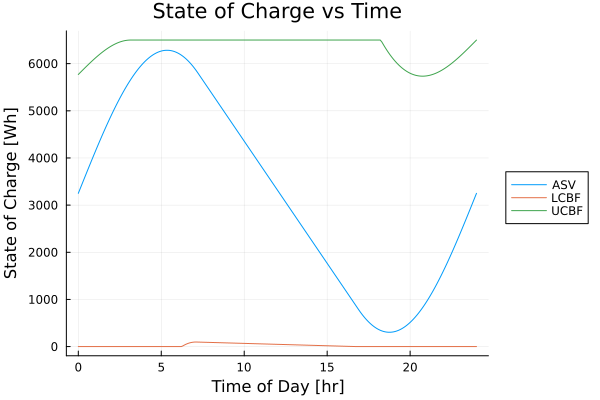

In [52]:
k_l = -1e-5; # Learning gain

xmax = 0; # best distance travel
pstar = 0;
num_iters = 100;
p_list = zeros(num_iters);
p_list[1] = 0.5; # Initial guess for p2
p2min = 1/(3*boat.k_m*(boat.v_max^2));
println("p2min: ", p2min);

x = zeros(n);
b = ones(n)*b_0;
v = ones(n)*boat.v_max;

for day = 1:1:num_iters

    global x = zeros(n);
    global b = ones(n)*b_0;
    global v = ones(n)*boat.v_max;

    p2 = p_list[day];
    println(p2);

    for j in 2:n
        i = j-1;
        if i == 1 # initial conditions
            global x[i] = 0;
            global b[i] = b_0;
        end
        # println(p2);
        # Compute unconstrained velocity and SOC
        global v[i] = sqrt(1/(3 * p2 * boat.k_m)); # removed negative sign from numerator to let p be positive
        b_dot = powermodel!(boat, dayOfYear, t[i], lat, v[i], b[i], Δt);

        if b[i] <= lcbf[i]
            global v[i] = 0;
        elseif b[i] >= ucbf[i]
            global v[i] = boat.v_max;
        end

        # Move boat
        global x[j] = x[i] + (v[i] * 60 * 60) * Δt;
        global b[j] = batterymodel!(boat, dayOfYear, t[i], lat, v[i], b[i], Δt);
    end

    # Learning adjustment
    if day < num_iters
        pbar = log10(p_list[day]) + k_l * (b[end] - b_0);
        p_list[day+1] = 10^pbar;
    end

    # Find optimal p2 and x
    if x[end] > xmax
        global xmax = x[end];
        global pstar = p2;
    end
end

# Plot SOC vs Time
plot(og_time, b, label="ASV");
plot!(og_time, lcbf, label="LCBF");
plot!(og_time, ucbf, label="UCBF");
xlabel!("Time of Day [hr]");
ylabel!("State of Charge [Wh]");
title!("State of Charge vs Time");
plot!(legend=:outerright)

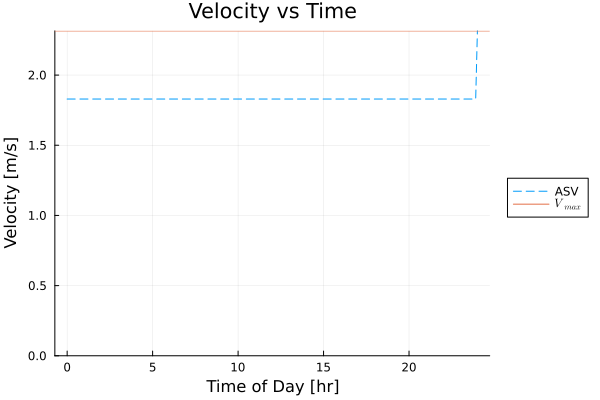

In [53]:
# Plot Velocity vs Time
plot(og_time, v, linestyle=:dash, label="ASV");
hline!([boat.v_max], label=L"$V_{max}$");
ylims!(0, boat.v_max);
xlabel!("Time of Day [hr]");
ylabel!("Velocity [m/s]");
title!("Velocity vs Time");
plot!(legend=:outerright)